val bovw

In [1]:
import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score 
import joblib

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load('/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Models/bovw_color_brisk.pkl'  )

# Get the path of the testing image(s) and store them in a list
test_path = '/media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color'  

testing_names = os.listdir(test_path)

In [3]:
# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]


In [4]:
for testing_name in testing_names:
    if not testing_name.endswith('.csv'):
        dir = os.path.join(test_path, testing_name)
        class_path = imglist(dir)
        image_paths+=class_path
        image_classes+=[class_id]*len(class_path)
        class_id+=1
        
# Create feature extraction and keypoint detector objects
    #SIFT is not available anymore in openCV    
# Create List where all the descriptors will be stored

In [5]:
print(len(image_classes))

1999


In [6]:
des_list = []

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
brisk = cv2.BRISK_create(30)


In [7]:
import cv2

# Iterate through image paths
for image_path in image_paths:
    # Read the image
    im = cv2.imread(image_path)
    
    # Check if the image is not empty
    if im is not None and im.size > 0:
        im = cv2.imread(image_path)
        kpts, des = brisk.detectAndCompute(im, None)
        des_list.append((image_path, des))
    else:
        print(f"Skipping {image_path} because it is empty or could not be loaded.")


Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Cat/11210.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Cat/11565.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Cat/11874.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Cat/11935.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Dog/11410.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Dog/11675.jpg because it is empty or could not be loaded.
Skipping /media/ryan/New Volume/datasets/kagglecatsanddogs_5340/PetImages/Val_Color/Dog/11849.jpg because it is empty or could not be loaded.
Skippi

In [8]:
# Filter out empty and None descriptors from descriptor_list
valid_descriptors = [descriptor for _ , descriptor in des_list if descriptor is not None and descriptor.ndim > 0]

# Stack all the valid descriptors vertically in a numpy array
if valid_descriptors:
    descriptors = np.concatenate(valid_descriptors, axis=0)
    print("Descriptors stacked successfully!")
else:
    print("No valid descriptors found.")


Descriptors stacked successfully!


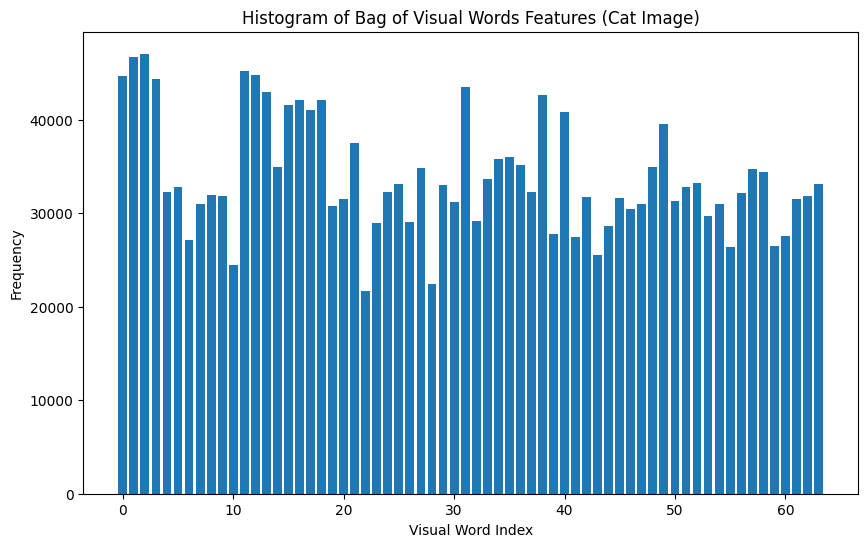

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out any empty descriptors
descriptors_filtered = [descriptor for descriptor in des_list[0][1] if len(descriptor) > 0]

# Assuming all descriptors have the same length or shape
# Convert the descriptors list into a numpy array
features_array = np.array(descriptors_filtered)

# Calculate the histogram of features
histogram = np.sum(features_array, axis=0)

# Display the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(histogram)), histogram)
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Histogram of Bag of Visual Words Features (Cat Image)')
plt.show()


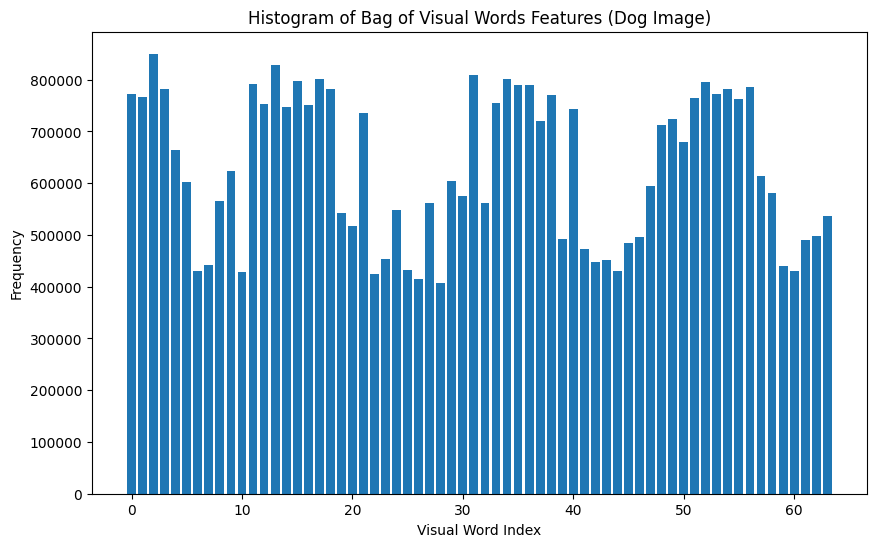

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out any empty descriptors
descriptors_filtered = [descriptor for descriptor in des_list[1597][1] if len(descriptor) > 0]

# Assuming all descriptors have the same length or shape
# Convert the descriptors list into a numpy array
features_array = np.array(descriptors_filtered)

# Calculate the histogram of features
histogram = np.sum(features_array, axis=0)

# Display the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(histogram)), histogram)
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Histogram of Bag of Visual Words Features (Dog Image)')
plt.show()


In [11]:
from scipy.cluster.vq import vq

test_features = np.zeros((len(image_paths), k), "float32")

# Iterate through descriptor list
for i in range(len(des_list)):
    if i >= len(test_features):
        print(f"Skipping descriptor {i} because index is out of bounds.")
        continue
    
    descriptors = des_list[i][1]
    
    # Skip None types
    if descriptors is None:
        print(f"Skipping descriptor {i} because it is None.")
        continue
    
    # Convert descriptors to NumPy array
    descriptors_array = np.array(descriptors)
    
    # Check for NaN or infinite values
    if not np.isnan(descriptors_array).any() and not np.isinf(descriptors_array).any():
        # Perform vector quantization
        words, distance = vq(descriptors_array, voc)
        
        # Update test_features only if indices are within bounds
        for w in words:
            if 0 <= w < k:  # Check if w is within the bounds of test_features
                test_features[i][w] += 1
            else:
                print(f"Skipping index {w} because it is out of bounds.")
    else:
        print(f"Skipping descriptor {i} because it contains NaN or infinite values.")


Skipping descriptor 1250 because it is None.


In [12]:
len(des_list)

1991

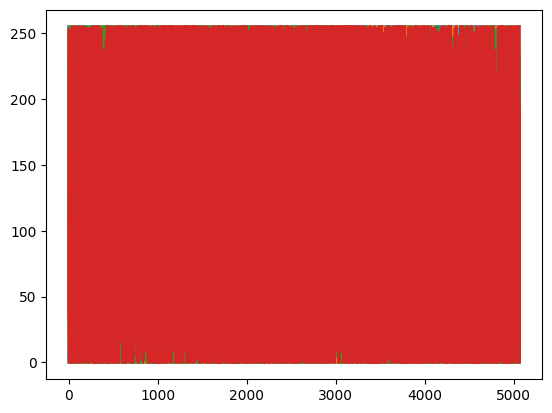

In [13]:
plt.plot(range(len(descriptors)), descriptors)
plt.show()

In [14]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [15]:
# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)


In [16]:
# Check lengths of both lists
print(len(classes_names))
print(len(image_classes))

image_classes[100]

2
1999


0

In [17]:
print(classes_names)

['Cat', 'Dog']


In [18]:
#Report true class names so they can be compared with predicted classes
true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))


true_class =['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 

accuracy =  0.6753376688344173
[[759 241]
 [408 591]]


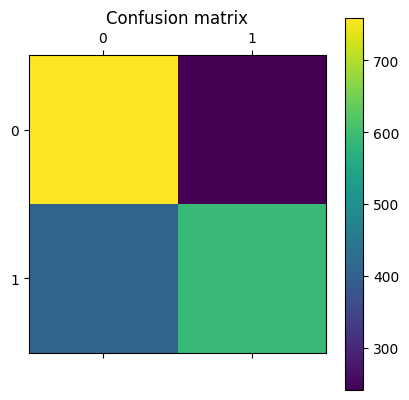

'\n#For classification of unknown files we can print the predictions\n#Print the Predictions \nprint ("Image =", image_paths)\nprint ("prediction ="  + str(predictions))\n\n#np.transpose to save data into columns, otherwise saving as rows\n\nnp.savetxt (\'mydata.csv\', np.transpose([image_paths, predictions]),fmt=\'%s\', delimiter=\',\', newline=\'\n\')\n'

In [19]:
def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions)
print (cm)

showconfusionmatrix(cm)

"""
#For classification of unknown files we can print the predictions
#Print the Predictions 
print ("Image =", image_paths)
print ("prediction ="  + str(predictions))

#np.transpose to save data into columns, otherwise saving as rows

np.savetxt ('mydata.csv', np.transpose([image_paths, predictions]),fmt='%s', delimiter=',', newline='\n')
"""

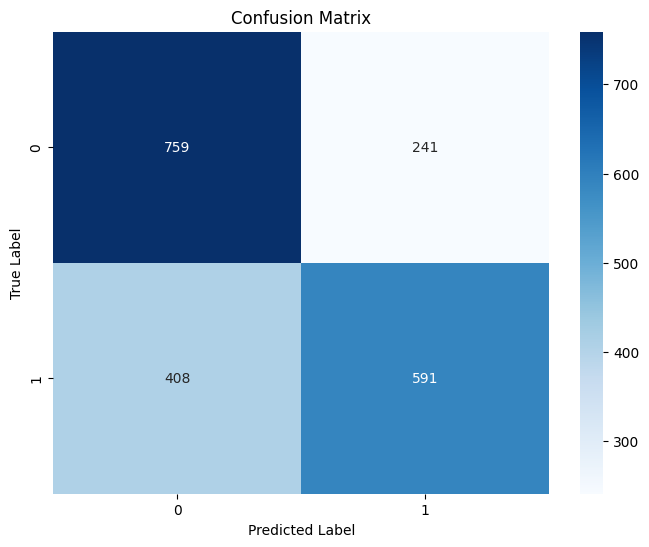

In [20]:
# Create a heatmap with numbers in each cell
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Class 0 - Correctly classified:


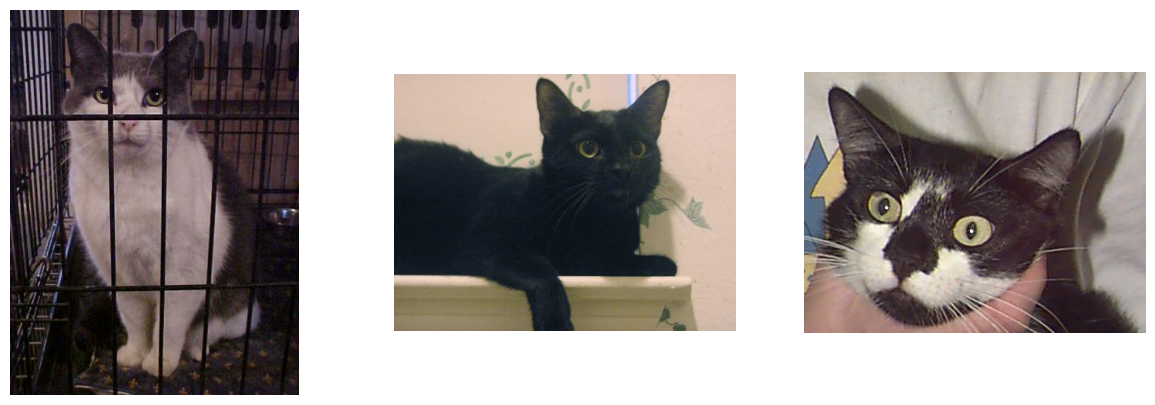

Class 0 - Incorrectly classified:


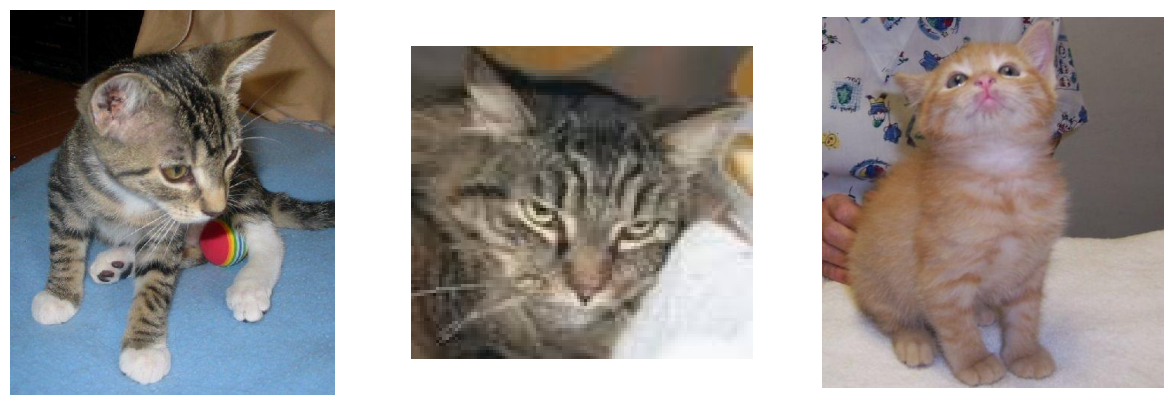

Class 1 - Correctly classified:


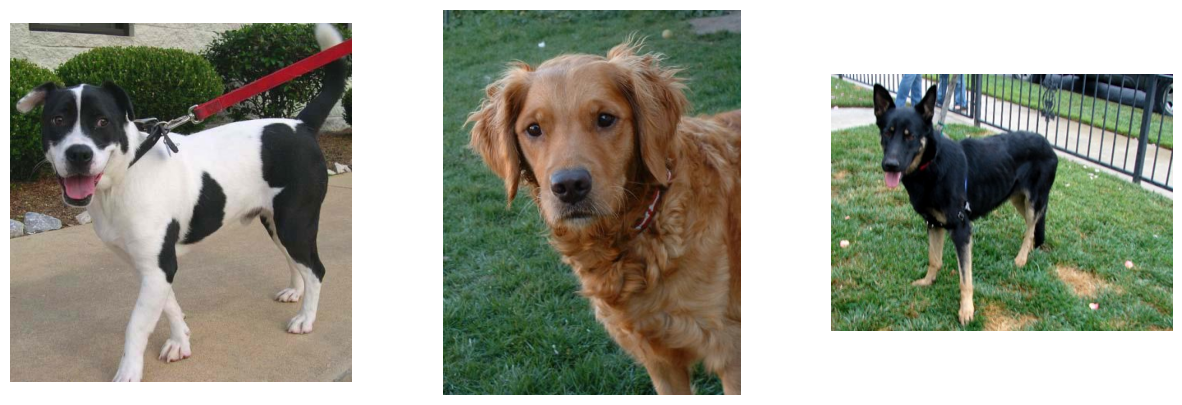

Class 1 - Incorrectly classified:


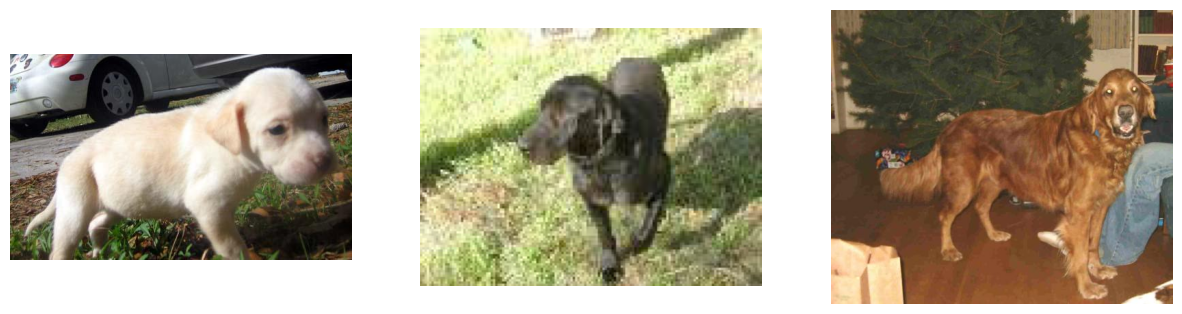

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

# Assuming true_class and predictions are defined earlier in your code
# Assuming image_paths contains the paths to the images

# Create a dictionary to store the indices of correct and incorrect classifications for each class
correct_indices = {0: [], 1: []}
incorrect_indices = {0: [], 1: []}

# Define a mapping from actual labels to numeric labels
label_mapping = {'Cat': 0, 'Dog': 1}

# Populate the correct and incorrect indices lists
for i in range(len(true_class)):
    true_label = label_mapping[true_class[i]]  # Map actual label to numeric label
    pred_label = label_mapping[predictions[i]]  # Map predicted label to numeric label
    if true_label == pred_label:
        correct_indices[true_label].append(i)
    else:
        incorrect_indices[true_label].append(i)

# Function to display images
def display_images_horizontally_color(image_paths, indices, num_samples=3):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))  # Adjust figsize as needed
    selected_indices = np.random.choice(indices, num_samples, replace=False)
    for i, idx in enumerate(selected_indices):
        image_path = image_paths[idx]
        image = cv2.imread(image_path)  # Read image in color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        axs[i].imshow(image)  # Display in color
        axs[i].axis('off')
    plt.show()

    
# Display successful and failed classifications for each class
for class_label in [0, 1]:
    print(f"Class {class_label} - Correctly classified:")
    display_images_horizontally_color(image_paths, correct_indices[class_label])
    print(f"Class {class_label} - Incorrectly classified:")
    display_images_horizontally_color(image_paths, incorrect_indices[class_label])


In [22]:

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
true_binary = lb.fit_transform(true_class)
true_binary = true_binary.flatten()  # Flatten to a 1D array if necessary

pred_binary = lb.transform(predictions)
pred_binary = pred_binary.flatten()  # Flatten to a 1D array if necessary


ROC AUC: 0.6752957957957958


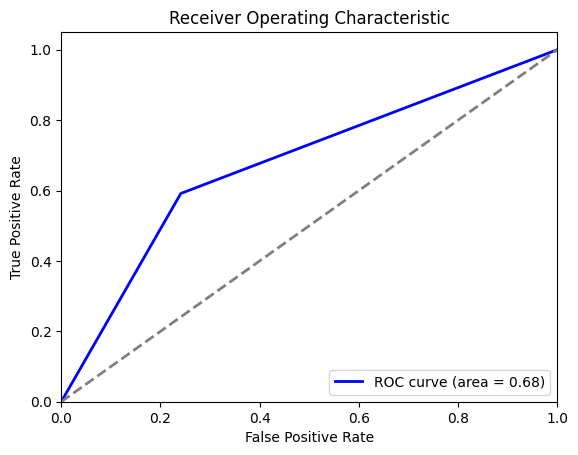

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# preds: Predicted probabilities from your new model
# true_labels: True class labels

# Check if the problem is binary or multi-class
num_classes = 2


# Binary classification
roc_auc = roc_auc_score(true_binary, pred_binary)
print(f'ROC AUC: {roc_auc}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_binary, pred_binary)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

